# Data Space Report


<img src="images/polito_logo.png" alt="Polito Logo" style="width: 200px;"/>


## Pittsburgh Bridges Data Set

<img src="images/andy_warhol_bridge.jpg" alt="Andy Warhol Bridge" style="width: 200px;"/>

    Andy Warhol Bridge - Pittsburgh.

Report created by Student Francesco Maria Chiarlo s253666, for A.A 2019/2020.

**Abstract**:The aim of this report is to evaluate the effectiveness of distinct, different statistical learning approaches, in particular focusing on their characteristics as well as on their advantages and backwards when applied onto a relatively small dataset as the one employed within this report, that is Pittsburgh Bridgesdataset.

**Key words**:Statistical Learning, Machine Learning, Bridge Design.

### Imports Section <a class="anchor" id="imports-section"></a>

In [1]:
# =========================================================================== #
# STANDARD IMPORTS
# =========================================================================== #
print(__doc__)

# Critical Imports
# --------------------------------------------------------------------------- #
import warnings; warnings.filterwarnings("ignore")

# Imports through 'from' syntax
# --------------------------------------------------------------------------- #
from pprint import pprint
from itertools import islice
from os import listdir; from os.path import isfile, join
# Standard Imports
# --------------------------------------------------------------------------- #
import copy; import os
import sys; import time
import itertools
import sklearn

# Imports through 'as' syntax
# --------------------------------------------------------------------------- #
import numpy as np; import pandas as pd

# Imports for handling graphics
# --------------------------------------------------------------------------- #
%matplotlib inline
# Matplotlib pyplot provides plotting API
import matplotlib as mpl
from matplotlib import pyplot as plt
import chart_studio.plotly.plotly as py
import seaborn as sns;  sns.set(style="ticks", color_codes=True) # sns.set()

Automatically created module for IPython interactive environment


In [2]:
# =========================================================================== #
# UTILS IMPORTS (Done by myself)
# =========================================================================== #
from utils.load_dataset_pittsburg_utils import load_brdiges_dataset; from utils.display_utils import *
from utils.preprocessing_utils import *; from utils.training_utils import *
from utils.sklearn_functions_custom import *; from utils.learning_curves_custom import *
from utils.training_utils_v2 import fit_by_n_components, fit_all_by_n_components, grid_search_all_by_n_components

In [3]:
# =========================================================================== #
# sklearn IMPORT
# =========================================================================== #
from sklearn.decomposition import PCA, KernelPCA

# Import scikit-learn classes: models (Estimators).
from sklearn.naive_bayes import GaussianNB, MultinomialNB   # Non-parametric Generative Model
from sklearn.linear_model import LogisticRegression         # Parametric Linear Discriminative Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC                          # Parametric Linear Discriminative "Support Vector Classifier"
from sklearn.tree import DecisionTreeClassifier      # Non-parametric Model
from sklearn.ensemble import RandomForestClassifier  # Non-parametric Model (Meta-Estimator, that is, an Ensemble Method)

In [4]:
# =========================================================================== #
# READ INPUT DATASET
# =========================================================================== #

dataset_path = 'C:\\Users\\Francesco\Documents\\datasets\\pittsburgh_dataset'
dataset_name = 'bridges.data.csv'

TARGET_COL = 'T-OR-D'  # Target variable name
dataset, feature_vs_values = load_brdiges_dataset(dataset_path, dataset_name)

In [5]:
columns_2_avoid = ['ERECTED', 'LENGTH', 'LOCATION']

In [6]:
# Make distinction between Target Variable and Predictors
# --------------------------------------------------------------------------- #

columns = dataset.columns  # List of all attribute names

# Get Target values and map to 0s and 1s
# y = np.array(list(map(lambda x: 0 if x == 1 else 1, dataset[TARGET_COL].values)))
y = np.array(list(map(lambda x: -1 if x == 1 else 1, dataset[TARGET_COL].values)))
print('Summary about Target Variable {target_col}')
print('-' * 50)
print(dataset[TARGET_COL].value_counts())

# Get Predictors
X = dataset.loc[:, dataset.columns != TARGET_COL].values

Summary about Target Variable {target_col}
--------------------------------------------------
2    57
1    13
Name: T-OR-D, dtype: int64


In [7]:
# Standardizing the features
# --------------------------------------------------------------------------- #
scaler_methods = ['minmax', 'standard', 'norm']
scaler_method = 'standard'
rescaledX = preprocessing_data_rescaling(scaler_method, X)

shape features matrix X, after normalizing:  (70, 11)


## Pricipal Component Analysis

In [8]:
n_components = rescaledX.shape[1]
pca = PCA(n_components=n_components)
# pca = PCA(n_components=2)

# X_pca = pca.fit_transform(X)
pca = pca.fit(rescaledX)
X_pca = pca.transform(rescaledX)

In [9]:
print(f"Cumulative varation explained(percentage) up to given number of pcs:")

tmp_data = []
principal_components = [pc for pc in '2,5,6,7,8,9,10'.split(',')]
for _, pc in enumerate(principal_components):
    n_components = int(pc)
    
    cum_var_exp_up_to_n_pcs = np.cumsum(pca.explained_variance_ratio_)[n_components-1]
    # print(f"Cumulative varation explained up to {n_components} pcs = {cum_var_exp_up_to_n_pcs}")
    # print(f"# pcs {n_components}: {cum_var_exp_up_to_n_pcs*100:.2f}%")
    tmp_data.append([n_components, cum_var_exp_up_to_n_pcs * 100])

tmp_df = pd.DataFrame(data=tmp_data, columns=['# PCS', 'Cumulative Varation Explained (percentage)'])
tmp_df.head(len(tmp_data))

Cumulative varation explained(percentage) up to given number of pcs:


,# PCS,Cumulative Varation Explained (percentage)
0,2,47.738342
1,5,75.856460
2,6,82.615768
3,7,88.413903
4,8,92.661938
5,9,95.976841
6,10,98.432807


#### Major Pros & Cons of PCA



## Learning Models <a class="anchor" id="learning-models"></a>

In [10]:
# Parameters to be tested for Cross-Validation Approach

estimators_list = [GaussianNB(), LogisticRegression(), KNeighborsClassifier(), SGDClassifier(), SVC(), DecisionTreeClassifier(), RandomForestClassifier()]
estimators_names = ['GaussianNB', 'LogRegr', 'Knn', 'SGD', 'SVC', 'DecisionTree', 'RandomForest']
plots_names = list(map(lambda xi: f"{xi}_learning_curve.png", estimators_names))

pca_kernels_list = ['linear', 'poly', 'rbf', 'cosine', 'sigmoid']
cv_list = [10, 9, 8, 7, 6, 5, 4, 3, 2]

parmas_logistic_regression = {
    'penalty': ('l1', 'l2', 'elastic', None),
    'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
    'fit_intercept': (True, False),
    'tol': (1e-4, 1e-3, 1e-2),
    'class_weight': (None, 'balanced'),
    'C': (10.0, 1.0, .1, .01, .001, .0001),
    'random_state': (0,),
}


parmas_knn_forest = {
    'n_neighbors': (2,3,4,5,6,7,8,9,10),
    'weights': ('uniform', 'distance'),
    'metric': ('euclidean', 'minkowski', 'manhattan'),
    'leaf_size': (5, 10, 15, 30),
    'algorithm': ('ball_tree', 'kd_tree', 'brute'),
}

parameters_sgd_classifier = {
    'loss': ('log', 'modified_huber'), # ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron')
    'penalty': ('l2', 'l1', 'elasticnet'),
    'alpha': (1e-1, 1e-2, 1e-3, 1e-4),
    'max_iter': (50, 100, 150, 200, 500, 1000, 1500, 2000, 2500),
    'learning_rate': ('optimal',),
    'tol': (None, 1e-2, 1e-4, 1e-5, 1e-6)
}

kernel_type = 'svm-rbf-kernel'
parameters_svm = {
    'gamma': (0.003, 0.03, 0.05, 0.5, 0.7, 1.0, 1.5),
    'max_iter':(1e+2, 1e+3, 2 * 1e+3, 5 * 1e+3, 1e+4, 1.5 * 1e+3),
    # 'penalty': ('l2','l1'),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid',],
    'C': (1e-4, 1e-3, 1e-2, 0.1, 1.0, 10, 1e+2, 1e+3),
    'probability': (True,), 
}

parmas_decision_tree = {
    'splitter': ('random', 'best'),
    'criterion':('gini', 'entropy'),
    'max_features': (None, 'auto', 'sqrt', 'log2')
}

parmas_random_forest = {
    'n_estimators': (3, 5, 7, 10, 30, 50, 70, 100, 150, 200),
    'criterion':('gini', 'entropy'),
    'bootstrap': (True, False)
}

param_grids = [parmas_logistic_regression, parmas_knn_forest, parameters_sgd_classifier, parameters_svm, parmas_decision_tree, parmas_random_forest]

N_CV, N_KERNEL, N_GS = 9, 4, 6

In [11]:
n_components=9
learning_curves_by_kernels(
# learning_curves_by_components(
    estimators_list[:], estimators_names[:],
    rescaledX, y,
    train_sizes=np.linspace(.1, 1.0, 10),
    n_components=9,
    pca_kernels_list=pca_kernels_list[0],
    verbose=0,
    by_pairs=True,
    savefigs=True,
    scoring='accuracy',
    figs_dest=os.path.join('figures', 'learning_curve', f"Pcs_{n_components}"), ignore_func=True,
    # figsize=(20,5)
)

In [12]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Kernel PCA: Linear | Knn
[*] Best Score:
0.9214285714285715


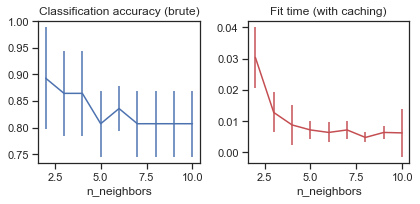

Classification score 0.9411764705882353 (pvalue : 0.009900990099009901)


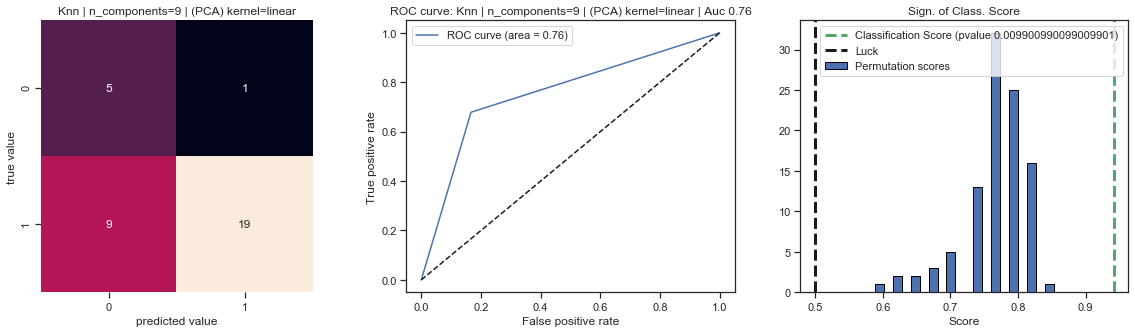

Kernel PCA: Poly | Knn
[*] Best Score:
0.8928571428571429


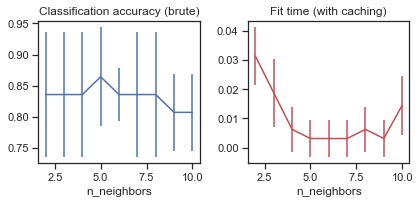

Classification score 0.9117647058823529 (pvalue : 0.009900990099009901)


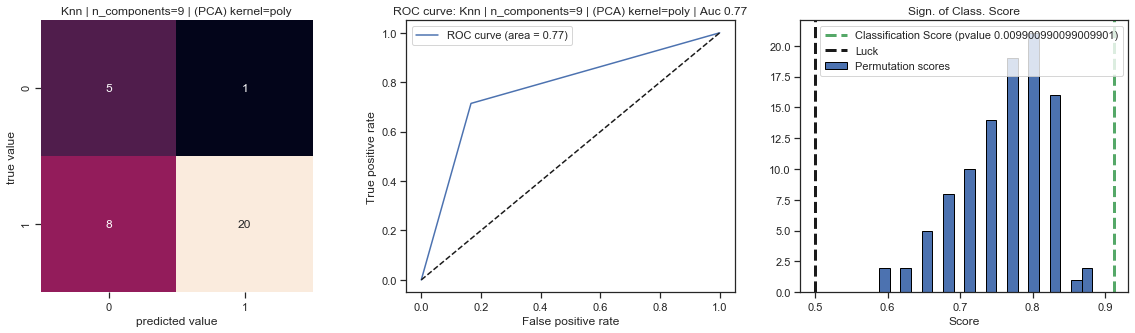

Kernel PCA: Rbf | Knn
[*] Best Score:
0.95


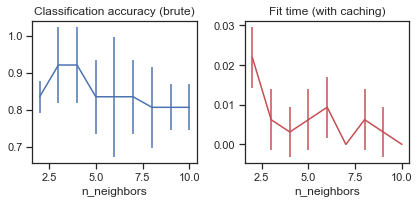

Classification score 0.8823529411764706 (pvalue : 0.009900990099009901)


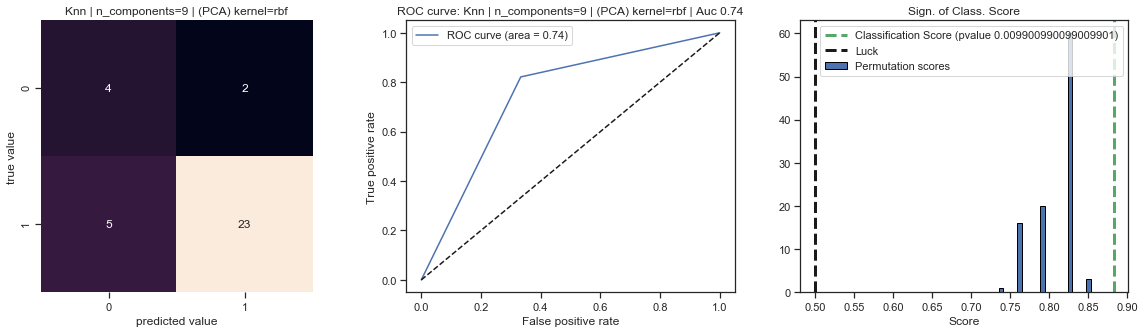

Kernel PCA: Cosine | Knn
[*] Best Score:
0.9214285714285715


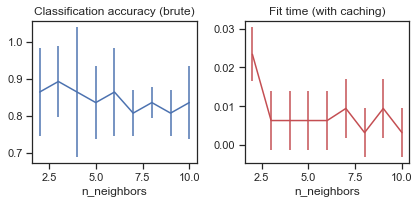

Classification score 0.9411764705882353 (pvalue : 0.009900990099009901)


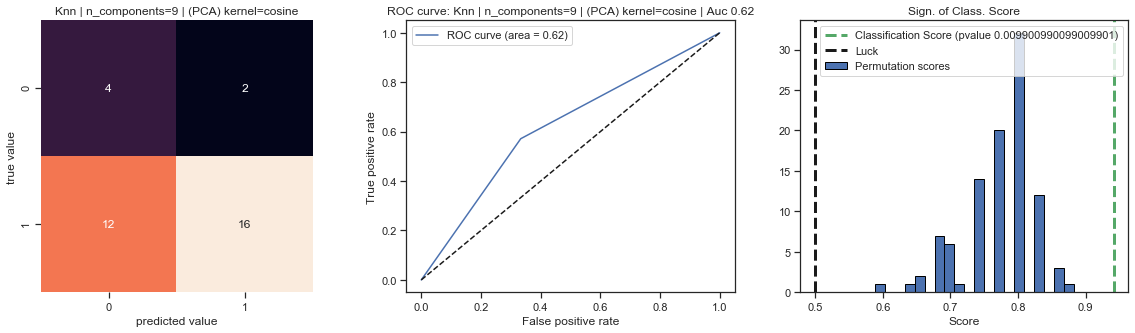

Kernel PCA: Sigmoid | Knn
[*] Best Score:
0.9214285714285715


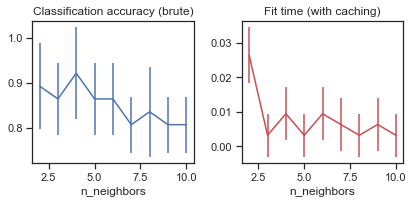

Classification score 0.8235294117647058 (pvalue : 0.18811881188118812)


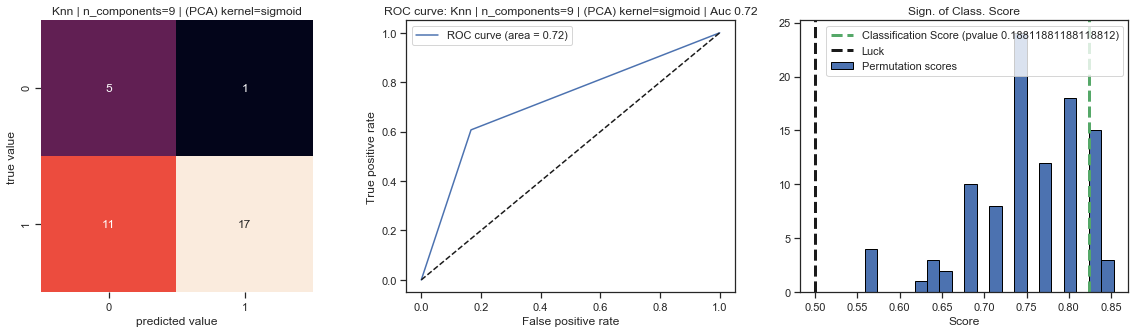

In [13]:
plot_dest = os.path.join("figures", "n_comp_9_analysis", "grid_search")
X = rescaledX

df_gs, df_auc_gs = grid_search_all_by_n_components(
    estimators_list=estimators_list[2], \
    param_grids=param_grids[1],
    estimators_names=estimators_names[2], \
    X=X, y=y,
    n_components=9,
    random_state=0, show_plots=False, show_errors=False, verbose=1, plot_dest=plot_dest, debug_var=False)
df_9, df_9_auc = df_gs, df_auc_gs

Looking at the results obtained running *Knn Classifier* against our dataset splitted into training set and test set and adopting a different kernel trick applied to *kernel-Pca* unsupervised preprocessing method we can state generally speaking that all the such a *Statistical Learning technique* leads to a sequence of results that on average are more than appreciable beacues of the accuracy scores obtained at test time which compared against the same score but related to train phase allows us to understand that during the model creation the resulting classifiers do not overfit to the data, and even when the training score was high it was still lower than the scores in terms of accuracy obtained from the Logisti Regression Models which overfit to the data. Moreover, looking at the weighted values of *Recall, Precision, and F1-Scores* we can notably claim that the classifiers based on Knn obtained good performance and and except for one trial where we got lower and worst results, when *Sigmoid Trick* is selected, in the remaning cases have gotten remarkable results. More precisely we can say what follows:
- speaking about __Linear kernel Pca based Knn Classifier__, when adoping the default threshold of *.5* for classification purposes we have a model that reaches an accuracy of *71%* at test time against an accuracy of *92%* at train step, while the Auc score reaches a value of *76%* with a Roc Curve that shows a behavior for which the model for a first set of thresholds let *TPR* grows faster than *FPR*, and only when we take into account larger thresholds we can understand that the trend is reversed. Looking at classification report we can see that the model has high precision and recall for class 1, so this means that the classifier has high confidence when predicting class 1 labels, instead it is less certain when predicting class 0 instances because has low precision, even if the model was able to predict correctly all the samples from class 0, leading to high recall.
- observing __Polynomial kernel Pca based Knn Estimator__, we can notice that such a model exploiting a default threshold of *.5* reaches an accuracy of *74%* at test time against an accuracy of *89%* at train step, while the Auc score reaches a value of *77%*. What we can immediately understand is that the second model we have trained for Knn classifier is able to better generalize because obtained a higher accuracy score for test set which is also less far from train accuracy score, moreover the model has a slightly greater precision and recall when referring to class 1, while the precision and recall about class 0 seem to be more or less the same.
- review __Rbf kernel Pca based Knn Classifier__, we can notice that such a model exploiting a default threshold of *.5* reaches an accuracy of *79%* at test time against an accuracy of *95%* at train step, while the Auc score reaches a value of *74%*. We can understand that even if this model, having selected *Rbf kernel Trick for kernel-Pca*, corresponds to the estimator that among Knn classifiers is the one with the best performance in terms of accuracy we notice that the corresponding auc score is less than the other first two analyzed trials where we end up saying that such classifiers lead to acceptable results. However, this method set with the hyper-params found by the grid-search algorithm reveals a higher value of precision related to class 0, meaning that *Rbf kernel Pca based Logisti Classifier* has a higher precision than previous models when classifying instances as belonging to class 0, while precisin and recall metrics for class 1 was more or less the same. This classifier is the one that we should select since it has higher precision values for better classifyng new instances.
- looking at __Cosine kernel Pca based Knn Classifier__, we can notice that such a model exploiting a default threshold of *.5* reaches an accuracy of *59%* at test time against an accuracy of *92%* at train step, while the Auc score reaches a value of *62%*. We can clearly see that that such a model corresponds to the worst solution amongst the models we have trained exploiting *Knn classifier*, because we can state that due to a mostly lower accuracy score obtained at test time than the accuracy score referred to training time the classifier seems to have overfit to the data. In particular speaking about Precision and Recall scores about class 1, from classification report, the model seems to be mostly precise when predicting class 1 as label for the instances to be classified, however was misclassifying nearly half of the samples from class 1. Furthermore, the model also do not obtain fine results in terms of metrics when we focus on class 0 precision and recall. This model is the oen we should avoid, and do not exploit.
- finally, referring to __Sigmoid kernel Pca based Knn Model__, we can notice that such a model exploiting a default threshold of *.5* reaches an accuracy of *65%* at test time against an accuracy of *92%* at train step, while the Auc score reaches a value of *72%*. It has values for performance metrics such as *precisio, recall, and F1-Score* which are more or less quyite similar to those of the first models trained for Knn classifier, that are those which are exploiting lienar and polynomial tricks, however this model misclassifyes larger number of class 1 instances lowering down the precision related to class 0, as well as lowering down recall from class 1. Also such a classifier with respect the first three trial is not sufficiently fine to be accepted so that we can exclude it from our choice.

In [14]:
create_widget_list_df([df_gs, df_auc_gs]) #print(df_gs); print(df_auc_gs)

Looking at the table dispalyed just above that shows the details about the selected values for hyper-parameters specified during grid search, in the different situations accordingly to the fixed kernel-trick for kernel Pca unsupervised method we can state that, referring to the first two columns of *Train and Test Accuracy*, we can recognize which trials lead to more overfit results such as for *Cosine, and Sigmoid Tricks* or less overfit solution such as in the case of *Linear, Polynomial, and Rbf Trick*. Speaking about the hyper-parameters, we can say what follows:
- looking at the *algorithm paramter*, which can be set alternatively as *brute, kd-tree, and ball-tree* where each algorithm represents an differen strategy for implementing neighbor-based learning with pros and cons in terms of requested training time, memory usage and inference performance in terms of elapsed time, we can clearly understand that the choice of the kind of kernel trick for performing kernel-Pca does not care since all the trials preferred and selectd *ball-tree* strategy to solve the problem. It means that the grid search algorithm, when forced to try all the possible combination recorded such a choice as the best hyper-param which leads to building an expensive data strucuture which aims at integrating somehow distance information to achieve better performance scores. So, this should make us reason about the fact that it is still a good choice or we should re-run the procedure excluding such algorithm. In fact the answer to such a issue depend on the forecast about the number of queryes we aim to solve. If it will be huge in future than ball-tree algorthm was a good choice and a goo parameter included amongst the hyper-params grid of values, otherwise we should get rid of it.
- referring to *leaf_size parameter*, we can notice that also here the choice of a specific kernel trick for performing kernel-Pca algorithm does not affect the value tha such a parameter has assumed amongst those proposed. However, recalling that leaf size hyper-param is used to monitor and control the tree-like structure of our solutions we can understand that since the value is pretty low the obtained trees were allowed to grow toward maximum depth.
- speaking about *distance parameter*, the best solution through different trials was *Euclidean distance*, which also corresponds to the default choice, furthermore the choice of a kernel trick in the context of the other grid values was not affecting the choice of *distance parameter*.
- *n_neighbors parameter* is the one which is most affected and influenced by the choice of kernel trick for performing the kernel-Pca preprocessing method, since three out of five trials found 3 as the best value which are *Linear, Poly and Cosine tricks*, however only the first two examples using such a low number of neighbors still obtained fine results, instead the best trial which is the classifier characterized from Rbf kernel trick for kernel-Pca has selected 7 as the best value for the number of neighbors meanning that such a classifier required a greater number of neighbor before estimating class label and also that the query time t solve the inference would be longer.
- lastly, the *weights param* is involved when we want to assign a certain weight to examples used during classification, where usually farway points will have less effect and nearby point grow their importance. The most frequent choice was represented by the *distance strategy*, which assign a weigh value to each sample of train set involved during classification a value proportional to the inverse of the distance of that sample from the query point. Only the Sigmoid kernel trick case instead adopted a weights strategy which corresponds to the default choice which is the uniform strategy.

If we imagine to build up an *Ensemble Classifier* from the family of *Average Methods*, which state that the underlying principle leading their creation requires to build separate and single classifiers than averaging their prediction in regression context or adopting a majority vote strategy for the classification context, we can claim that amongst the purposed Knn classifier, for sure, we could employ the classifier foudn from the first three trials because of their performance metrics and also because Ensemble Methods such as Bagging Classifier, usually work fine exploiting an ensemble of independent and fine tuned classifier differently from Boosting Methods which instead are based on weak learners.

### Improvements and Conclusions <a class="anchor" id="Improvements-and-conclusions"></a>

### References  <a class="anchor" id="references"></a>
- Data Domain Information part:
    - (Deck) https://en.wikipedia.org/wiki/Deck_(bridge)
    - (Cantilever bridge) https://en.wikipedia.org/wiki/Cantilever_bridge
    - (Arch bridge) https://en.wikipedia.org/wiki/Deck_(bridge)
- Machine Learning part:
    - (Theory Book) https://jakevdp.github.io/PythonDataScienceHandbook/
    - (Decsion Trees) https://scikit-learn.org/stable/modules/tree.html#tree
    - (SVM) https://scikit-learn.org/stable/modules/svm.html
    - (PCA) https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- Chart part:
    - (Seaborn Charts) https://acadgild.com/blog/data-visualization-using-matplotlib-and-seaborn
- Markdown Math part:
    - https://share.cocalc.com/share/b4a30ed038ee41d868dad094193ac462ccd228e2/Homework%20/HW%201.2%20-%20Markdown%20and%20LaTeX%20Cheatsheet.ipynb?viewer=share
    - https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html
    
#### others
- Plots:
    - (Python Plot) https://www.datacamp.com/community/tutorials/matplotlib-tutorial-python?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=255798340456&utm_targetid=aud-299261629574:dsa-473406587955&utm_loc_interest_ms=&utm_loc_physical_ms=1008025&gclid=Cj0KCQjw-_j1BRDkARIsAJcfmTFu4LAUDhRGK2D027PHiqIPSlxK3ud87Ek_lwOu8rt8A8YLrjFiHqsaAoLDEALw_wcB
- Third Party Library:
    - (statsmodels) https://www.statsmodels.org/stable/index.html#
- KDE:
    - (TUTORIAL) https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
- Metrics:
    - (F1-Accuracy-Precision-Recall) https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c